In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
import matplotlib.ticker as mtick
from scipy.optimize import curve_fit
from labellines import *
import pandas as pd
from matplotlib import rc
import glob
from copy import deepcopy as dc
import csv
import matplotlib.patches as patches
import matplotlib

# Define Parameters

In [2]:
G = 6.67e-11 #[m^3/kg s^2] Big G
mu0 = 1.26e-6 #[H/m] Magnetic permeability of free space

Rc = 380e3 #[m] Core Radius
Ric = 280e3 #[m] Inner Core Radius
Rp = 1737e3 #[m] Lunar Radius
rho_Fe = 8000. #[kg/m^3] density of iron
rho_avg = 3346. #[kg/m^3] density of Moon
T0 = 1800. #[K] initial average temperature of Moon
Vc = 4./3.*np.pi*Rc**3 #[m^3] Core volume
Cp = 850 #[J/kg K] Heat capacity (of Iron)
c_Fe = 450 #[J/ kg K] Specific Heat Capacity (of Iron)
L = 300e3 #[J/K] Latent Heat of Fusion (Iron)
P0 = 5e9 #[Pa] Pressure at the center of the core

F = 0.05 #Efficiency factor
fdip = 1 #Ratio of dipolar to total magnetic field strength (0.14-1)
fohm = 1 #Ratio of ohmic to total dissipation
c = 0.63 #Constant of proportionality

HU = 9.5e-5 #[W/kg] Heat generation rate for natural uranium
HTH = 2.6e-5 #[W/kg] Heat generation rate for thorium
HK = 3.5e-9 #[W/kg] Heat generation rate for natural potassium
lam_K = 5.5e-10 #[yr^-1] Decay constant for potassium
lam_Th = 5.0e-11 #[yr^-1] Decay constant for thorium
lam_U = 1.6e-10 #[yr^-1] Decay constant for uranium
TBMu = 1.5e15 #[kg] Total abundance of uranium in the bulk Moon
ThU = 3.7 #Ratio of thorium to uranium
KU = 2500 #Ratio of potassium to uranium

cD = 0.47 #Drag coefficient of a sphere
g = 1.62 #[m/s^2] Lunar gravitational acceleration
rho_s = 3450 #[kg/m^3] Estimate of silicate density

rho_b = 6000 #[kg/m^3] Blob density (<8000 so it'll float)

k = 79.5 #[W/m K] thermal conductivity of Fe
alpha = k/(rho_Fe*Cp) #[m^2/s] Thermal diffusivity of Fe

# Function Set Up

In [3]:
def settling_velocity(R, n):
    return 2*(rho_b-rho_s) * g * R**2 / (9*n)

def sink_time(R,n):
    return (Rp-Rc) / settling_velocity(R, n)

def temps(r, t, dT, Tc, L):
    if np.shape(r) == () and np.shape(t) == ():
        s = 0
    elif np.shape(t) == ():
        s = np.zeros(np.shape(r))
    elif np.shape(r) == ():
        s = np.zeros(np.shape(t))
    else:
        s = np.zeros((len(r), len(t)))
        
    for n in range(1,int(1e5)):
        s += 4*dT/(np.pi*(2*n-1)) * np.sin((2*n-1)*np.pi*r / (2*L)) * np.exp(-alpha*((2*n-1)*np.pi/(2*L))**2*t)
        
    return Tc - s

def adiabat(Tc):
    return 4*np.pi*G*alpha*rho_Fe*Tc*k*Rc / (3*Cp)

def fluxCMB(t, L, dT0):
    if np.shape(dT0) != () and np.shape(t) != ():
        q = np.zeros((len(dT0), len(t)))
#     elif np.shape(t) == ():
#         q = np.zeros(np.shape(dT0))
#     elif np.shape(dT0) == ():
#         q = np.zeros(np.shape(t))
    else:
        q = 0.
    
    for n in range(1,int(1e5)):
        q += 2*k*dT0/L * np.exp(-alpha*((2*n-1)*np.pi/(2*L))**2*t)
        
    return q - adiabat(1700) #minimized adiabat

def imp_from_crater(D):
    rho_imp = 1
    rho_targ = 1
    v = 2/np.sqrt(2) * 7.3e3 #[m/s] impactor velocity, smallest v --> largest impactor size
    g = 1.62 #[m/s^2] Lunar gravity
    Dsc = 15e3 #[m]
    ang = np.pi / 4 #[rad]
    return (D / 1.52 * (rho_imp / rho_targ)**-0.38 * v**-0.5 * \
                g**0.25 * Dsc**0.13 * np.sin(ang)**-0.38) ** (1/0.88)

def core_size(R):
    #not sure where this came from, but 3/17~0.3*3500/6000 so it should be ok
    return (3/17)**(1/3)*R

def layer(rb):
    return (rb**3 + Rc**3) ** (1/3) - Rc
        
def B_surface(E, delta_t):
    delta_t *= 3.154e7 #convert yrs to s
    f_dip=0.14
    Ac = 4*np.pi*Rc**2
    ad = adiabat(1700) #minimized adiabat
    if type(E) != np.ndarray and ad < E / (Ac*delta_t):
        Bs = 2.2e-5*f_dip*(E / (Ac*delta_t) - ad)**(1./3.) * 10**6
    elif type(E) != np.ndarray:
        Bs = 0.
    else:
        Bs = np.zeros(np.shape(E))     
        ind = np.where(ad < E / (Ac*delta_t))
        Bs[ind] = 2.2e-5*f_dip*(E[ind] / (Ac*delta_t) - ad)**(1./3.) * 10**6
    
    return Bs

def lastB(impR, dT0, tmax): #tmax in days
    blob = core_size(impR)
    L = layer(blob)
    ts = np.linspace(1, tmax*86400, num=1000)
    dt = np.nanmean(np.diff(ts))
    t = tmax*86400
    q = fluxCMB(t, L, dT0)
    f_dip = 1/7
    
    if type(q) != np.ndarray and q > 0.:
        Bs = 2.2e-5*f_dip*(q)**(1./3.) * 10**6
    elif type(q) != np.ndarray:
        Bs = 0.
    else:
        Bs = np.zeros(np.shape(q))     
        ind = np.where(q > 0.)
        Bs[ind] = 2.2e-5*f_dip*(q[ind])**(1./3.) * 10**6
        
    return Bs

In [109]:
lastB(max_R*0.03, 1000, 1)

0.0

# Figure 2)

In [14]:
rs = np.linspace(20e3, 160e3, 100) #160 is new largest SPA impactor diam
ds = np.linspace(0,1000,100)

s = []
err = []

for d in ds:
    B = lastB(rs, d, 2.)
    s.append(np.nanmean(B))
    err.append(np.std(B))
    
s = np.asarray(s)
err = np.asarray(err)

In [ ]:
full2 = {'Temp Differences':ds, 
         'Intensity at 2 days':s,
        }

np.save('StrengthAt2Days.npy', full2)

In [ ]:
csv_file = 'StrengthAt2Days.csv'
df = pd.DataFrame(full2)
df.to_csv(csv_file, index=False)

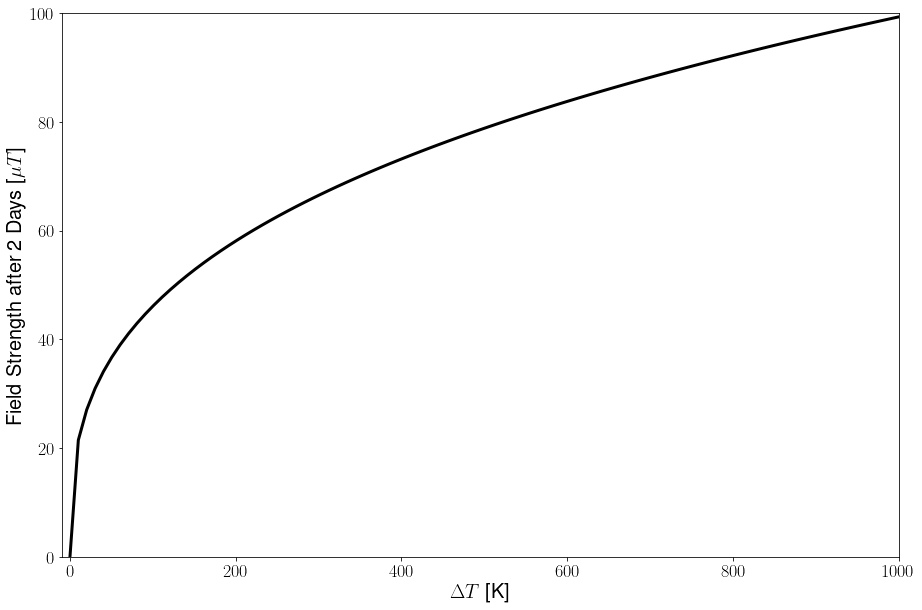

In [6]:
plt.figure(figsize=(15,10))
plt.style.use('default')
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
# plt.errorbar(ds, s, yerr=3*err, fmt='o')
plt.plot(ds, s, 'k', linewidth=3.)
# plt.plot(ds, s2, 'r--', linewidth=3.)
plt.xlim(-10,1000)
plt.ylim(0,100)
plt.tick_params(labelsize=18)
plt.xlabel(r'$\Delta T$ [K]', fontsize=20)
plt.ylabel(r'Field Strength after 2 Days [$\mu T$]', fontsize=20)
# plt.savefig('PaperFigs/fieldStrengthAt2Days.pdf', bbox_inches='tight')
plt.show()

# Figure 3)

In [47]:
max_R = imp_from_crater(2400e3)/2
rs = np.linspace(20e3, max_R, 1000)
rs2 = 0.3*rs #Kendall & Melosh f_sink
rs3 = 0.67*rs #10x Kendall & Melosh f_sink
dT = 1000
ts = np.linspace(2, 750, 1000)
thresh = []
thresh2 = []
thresh3 = []

for r in rs:
    B = lastB(r, dT, ts)
    thresh.append(B)
    
for r in rs2:
    B = lastB(r, dT, ts)
    thresh2.append(B)
    
for r in rs3:
    B = lastB(r, dT, ts)
    thresh3.append(B)
    
thresh = np.asarray(thresh)
thresh2 = np.asarray(thresh2)
thresh3 = np.asarray(thresh3)

In [112]:
np.nanmin(np.where(thresh3[-1,:] < 40))

361

In [113]:
ts[361]

777.841107128649

In [48]:
max_ts40 = []
max_ts40_v2 = []
max_ts40_v3 = []

for i in range(len(rs)):
    Bs = thresh[i,:]
    Bs_v2 = thresh2[i,:]
    Bs_v3 = thresh3[i,:]
    try:
        max_ts40.append(ts[np.nanmin(np.where(Bs < 40)[0])])
    except:
        max_ts40.append(np.nan)
        
    try:
        max_ts40_v2.append(ts[np.nanmin(np.where(Bs_v2 < 40)[0])])
    except:
        max_ts40_v2.append(np.nan)
        
    try:
        max_ts40_v3.append(ts[np.nanmin(np.where(Bs_v3 < 40)[0])])
    except:
        max_ts40_v3.append(np.nan)
        
max_ts40 = np.asarray(max_ts40)
max_ts40_v2 = np.asarray(max_ts40_v2)
max_ts40_v3 = np.asarray(max_ts40_v3)

In [ ]:
full3 = {'Impactor Diameters':rs*2/1e3, 
         'Above 40uT':max_ts4,
        }

np.save('Below40uT_1000K.npy', full3)

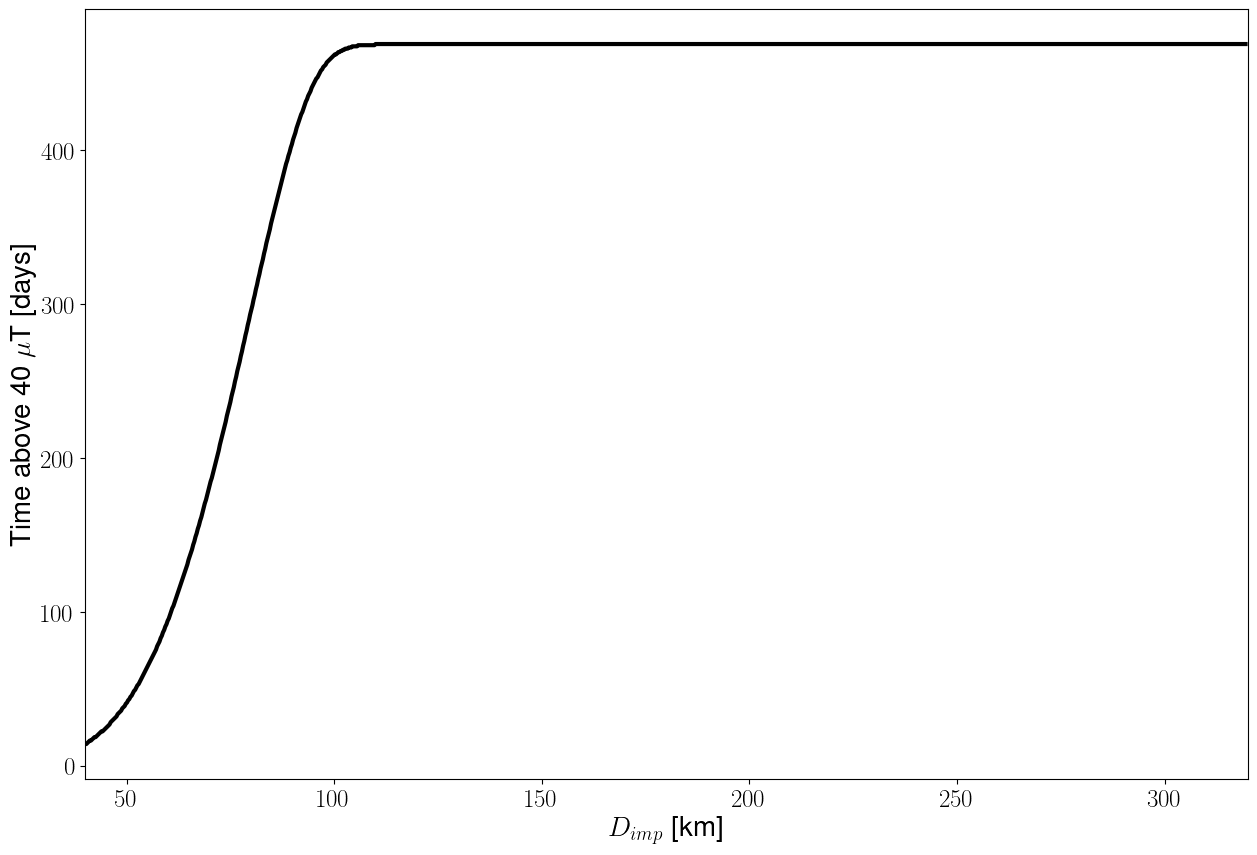

In [78]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.plot(rs/1e3*2, max_ts40, 'k', linewidth=3., label=r'$f_{sink}=1$')
plt.plot(rs/1e3*2, max_ts40_v3, 'g', linewidth=3., label=r'$f_{sink}=0.3$')
plt.plot(rs/1e3*2, max_ts40_v2, 'b', linewidth=3., label=r'$f_{sink}=0.03$')


plt.xlabel(r'$D_{imp}$ [km]', fontsize=20)
plt.ylabel(r'Time above 40 $\mu$T [days]', fontsize=20)
plt.xlim(40,320)
plt.tick_params(labelsize=18)

# labelLines(plt.gca().get_lines(),fontsize=18)
plt.legend(fontsize=18)

plt.savefig('PaperFigs/below40uT_1000K_v2.pdf', bbox_inches='tight')

plt.show()

# Figure 4)

In [83]:
max_R = imp_from_crater(2400e3)/2
rs = np.linspace(20e3, max_R, 1000)
rs2 = 0.3*rs #Kendall & Melosh f_sink
rs3 = 0.67*rs #10x Kendall & Melosh f_sink
dT = 1000
ts = np.logspace(np.log10(2),np.log10(20000*365),num=1000)
thresh = []
thresh2 = []
thresh3 = []

for r in rs:
    B = lastB(r, dT, ts)
    thresh.append(B)
    
for r in rs2:
    B = lastB(r, dT, ts)
    thresh2.append(B)
    
for r in rs3:
    B = lastB(r, dT, ts)
    thresh3.append(B)
    
thresh = np.asarray(thresh)
thresh2 = np.asarray(thresh2)
thresh3 = np.asarray(thresh3)

In [23]:
max_ts5 = []
max_ts10 = []
max_ts20 = []
max_ts30 = []

for i in range(len(rs)):
    Bs = thresh[i,:]
    try:
        max_ts5.append(ts[np.nanmin(np.where(Bs < 5)[0])])
    except:
        max_ts5.append(np.nan)
        
    try:
        max_ts10.append(ts[np.nanmin(np.where(Bs < 10)[0])])
    except:
        max_ts10.append(np.nan)
        
    try:
        max_ts20.append(ts[np.nanmin(np.where(Bs < 20)[0])])
    except:
        max_ts20.append(np.nan)
        
    try:
        max_ts30.append(ts[np.nanmin(np.where(Bs < 30)[0])])
    except:
        max_ts30.append(np.nan)

        
max_ts5 = np.asarray(max_ts5)
max_ts10 = np.asarray(max_ts10)
max_ts20 = np.asarray(max_ts20)
max_ts30 = np.asarray(max_ts30)

In [84]:
max_ts5_v2 = []
max_ts10_v2 = []
max_ts20_v2 = []
max_ts30_v2 = []
max_ts5_v3 = []
max_ts10_v3 = []
max_ts20_v3 = []
max_ts30_v3 = []

for i in range(len(rs)):
    Bs2 = thresh2[i,:]
    Bs3 = thresh3[i,:]
    try:
        max_ts5_v2.append(ts[np.nanmin(np.where(Bs2 < 5)[0])])
    except:
        max_ts5_v2.append(np.nan)
    try:
        max_ts5_v3.append(ts[np.nanmin(np.where(Bs3 < 5)[0])])
    except:
        max_ts5_v3.append(np.nan)
    try:
        max_ts10_v2.append(ts[np.nanmin(np.where(Bs2 < 10)[0])])
    except:
        max_ts10_v2.append(np.nan)
    try:
        max_ts10_v3.append(ts[np.nanmin(np.where(Bs3 < 10)[0])])
    except:
        max_ts10_v3.append(np.nan)        
    try:
        max_ts20_v2.append(ts[np.nanmin(np.where(Bs2 < 20)[0])])
    except:
        max_ts20_v2.append(np.nan)
    try:
        max_ts20_v3.append(ts[np.nanmin(np.where(Bs3 < 20)[0])])
    except:
        max_ts20_v3.append(np.nan)        
    try:
        max_ts30_v2.append(ts[np.nanmin(np.where(Bs2 < 30)[0])])
    except:
        max_ts30_v2.append(np.nan)
    try:
        max_ts30_v3.append(ts[np.nanmin(np.where(Bs3 < 30)[0])])
    except:
        max_ts30_v3.append(np.nan)
        
max_ts5_v2 = np.asarray(max_ts5_v2)
max_ts10_v2 = np.asarray(max_ts10_v2)
max_ts20_v2 = np.asarray(max_ts20_v2)
max_ts30_v2 = np.asarray(max_ts30_v2)

max_ts5_v3 = np.asarray(max_ts5_v3)
max_ts10_v3 = np.asarray(max_ts10_v3)
max_ts20_v3 = np.asarray(max_ts20_v3)
max_ts30_v3 = np.asarray(max_ts30_v3)

In [ ]:
full4 = {'Impactor Diameters':rs*2/1e3, 
         'Above 5uT':max_ts5,
         'Above 10uT':max_ts10,
         'Above 20uT':max_ts20,
         'Above 30uT':max_ts30,
        }

np.save('BelowThreshold_1000K.npy', full4)

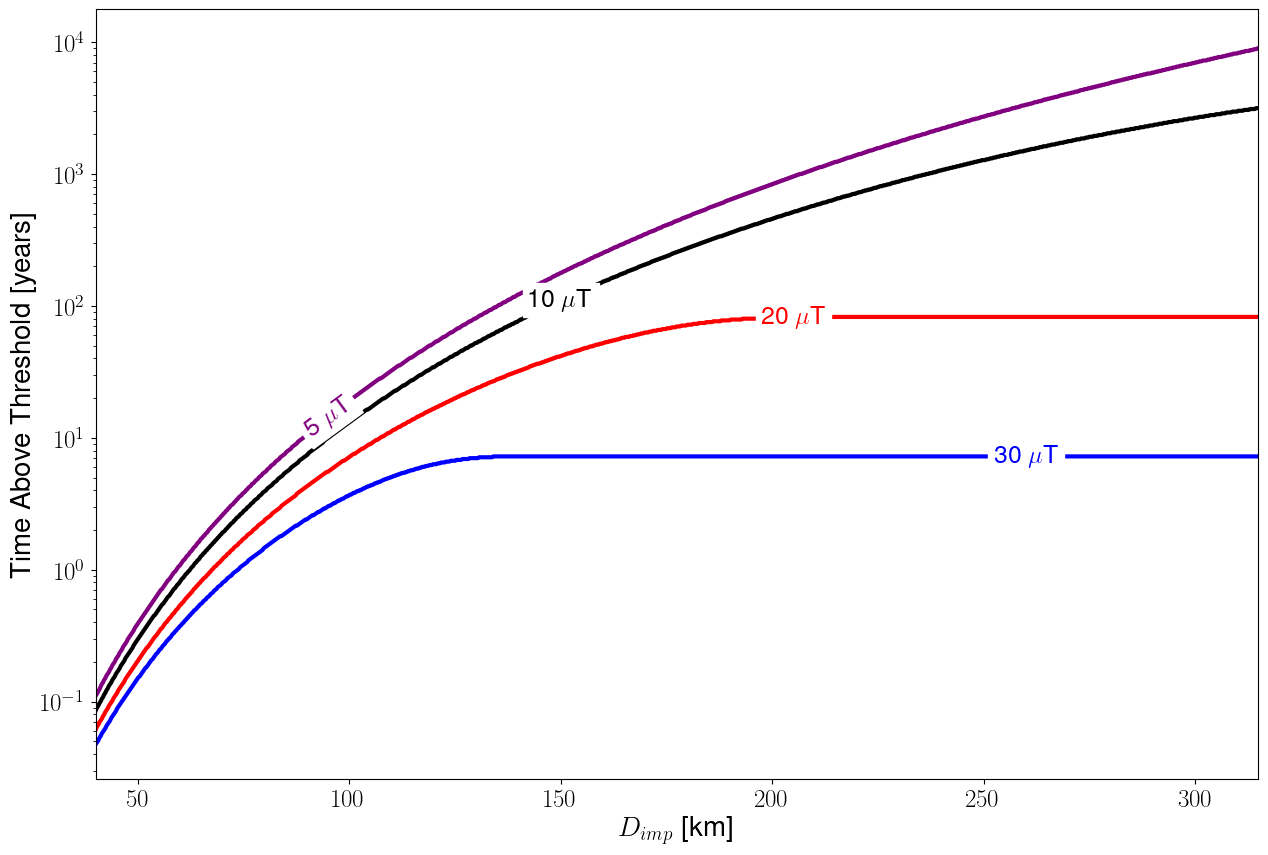

In [95]:
fig, ax = plt.subplots(1,1,figsize=(15,10))

rs = np.linspace(20e3, max_R, 1000)

plt.semilogy(rs/1e3*2, max_ts5/365, 'purple', linewidth=3., label=r'5 $\mu$T')
plt.semilogy(rs/1e3*2, max_ts10/365, 'k', linewidth=3., label=r'10 $\mu$T')
plt.semilogy(rs/1e3*2, max_ts20/365, 'r', linewidth=3., label=r'20 $\mu$T')
plt.semilogy(rs/1e3*2, max_ts30/365, 'b', linewidth=3., label=r'30 $\mu$T')

# plt.semilogy(rs/1e3*2, max_ts5_v3/365, 'purple', linestyle='--', linewidth=3.,)
# plt.semilogy(rs/1e3*2, max_ts10_v3/365, 'k--', linewidth=3.,)
# plt.semilogy(rs/1e3*2, max_ts20_v3/365, 'r--', linewidth=3.,)
# plt.semilogy(rs/1e3*2, max_ts30_v3/365, 'b--', linewidth=3.,)

# plt.semilogy(rs/1e3*2, max_ts5_v2/365, 'purple', linestyle='-.', linewidth=3.,)
# plt.semilogy(rs/1e3*2, max_ts10_v2/365, 'k-.', linewidth=3.,)
# plt.semilogy(rs/1e3*2, max_ts20_v2/365, 'r-.', linewidth=3.,)
# plt.semilogy(rs/1e3*2, max_ts30_v2/365, 'b-.', linewidth=3.,)

plt.xlabel(r'$D_{imp}$ [km]', fontsize=20)
plt.ylabel(r'Time Above Threshold [years]', fontsize=20)
plt.xlim(40,315)
plt.tick_params(labelsize=18)

labelLines(plt.gca().get_lines(),fontsize=18)
# plt.legend(fontsize=18)

# plt.savefig('PaperFigs/belowThreshold_1000K_v2.pdf', bbox_inches='tight')
plt.show()

# Figure 5)

In [99]:
basins = np.asarray([417e3, 937e3, 1321e3, 2400e3]) #diameters from Neumann+ 2015
imps = imp_from_crater(basins)/2 #need their radii, scaling law from Johnson+ 2017


ts = np.logspace(0, 8, num=1000)

SPA = lastB(imps[3], 1000, ts)
Im = lastB(imps[2], 1000, ts)
Or = lastB(imps[1], 1000, ts)
Kor = lastB(imps[0], 1000, ts)


In [107]:
SPA3[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [114]:
SPA2 = lastB(imps[3]*0.67, 1000, ts)
Im2 = lastB(imps[2]*0.67, 1000, ts)
Or2 = lastB(imps[1]*0.67, 1000, ts)
Kor2 = lastB(imps[0]*0.67, 1000, ts)

In [115]:
SPA3 = lastB(imps[3]*0.3, 1000, ts)
Im3 = lastB(imps[2]*0.3, 1000, ts)
Or3 = lastB(imps[1]*0.3, 1000, ts)
Kor3 = lastB(imps[0]*0.3, 1000, ts)

In [ ]:
full5 = {'time':ts, 
         'SPA':SPA,
         'Imbrium':Im,
         'Orientale':Or,
         'Korolev':Kor
        }

np.save('ParticularCasesData.npy', full5)

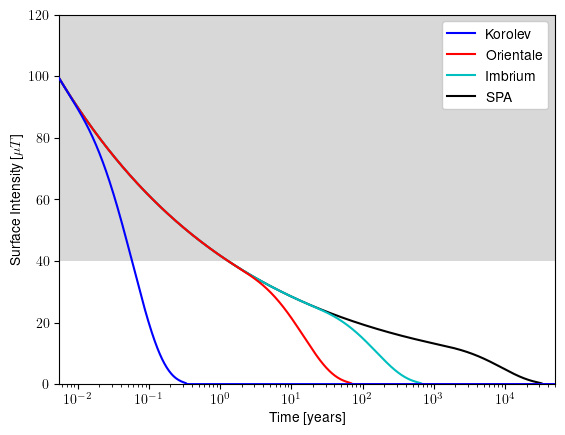

In [119]:
fig = plt.figure() 
ax = fig.add_subplot(111)

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
ts = np.logspace(0, 8, num=1000)

plt.semilogx(ts/365, Kor, 'b', label=r'Korolev', zorder=3)
plt.semilogx(ts/365, Or, 'r', label='Orientale', zorder=2)
plt.semilogx(ts/365, Im, 'c', label='Imbrium', zorder=1)
plt.semilogx(ts/365, SPA, 'k', label='SPA', zorder=0)

# plt.semilogx(ts/365, Kor2, 'b--', zorder=3)
# plt.semilogx(ts/365, Or2, 'r--', zorder=2)
# plt.semilogx(ts/365, Im2, 'c--', zorder=1)
# plt.semilogx(ts/365, SPA2, 'k--', zorder=0)

# plt.semilogx(ts/365, Kor3, 'b-.', zorder=3)
# plt.semilogx(ts/365, Or3, 'r-.', zorder=2)
# plt.semilogx(ts/365, Im3, 'c-.', zorder=1)
# plt.semilogx(ts/365, SPA3, 'k-.', zorder=0)

plt.xlabel('Time [years]')
plt.ylabel(r'Surface Intensity [$\mu T$]')


rect = patches.Rectangle((1/365,40),1e5,80,facecolor='grey', alpha=0.3)
ax.add_patch(rect)

plt.xlim(2/365,5e4)
plt.ylim(0,120)
plt.legend(framealpha=1.)

# plt.savefig('PaperFigs/Cases.pdf', bbox_inches='tight')

plt.show()

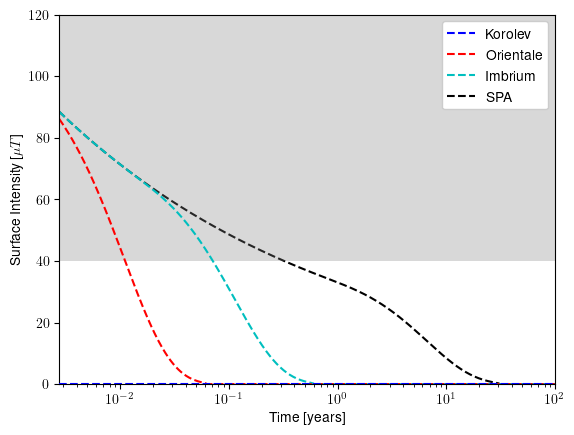

In [75]:
fig = plt.figure() 
ax = fig.add_subplot(111)

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
ts = np.logspace(0, 8, num=1000)

plt.semilogx(ts/365, Kor2, 'b--', label=r'Korolev', zorder=3)
plt.semilogx(ts/365, Or2, 'r--', label=r'Orientale', zorder=2)
plt.semilogx(ts/365, Im2, 'c--', label=r'Imbrium', zorder=1)
plt.semilogx(ts/365, SPA2, 'k--', label=r'SPA', zorder=0)

plt.xlabel('Time [years]')
plt.ylabel(r'Surface Intensity [$\mu T$]')


rect = patches.Rectangle((1/365,40),1e5,80,facecolor='grey', alpha=0.3)
ax.add_patch(rect)

plt.xlim(1/365,100)
plt.ylim(0,120)
plt.legend(framealpha=1.)

plt.show()

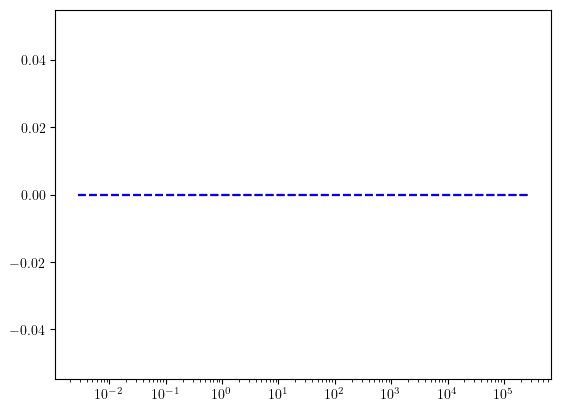

In [105]:
plt.semilogx(ts/365, Kor3, 'b--', label=r'Korolev', zorder=3)
plt.semilogx(ts/365, Or3, 'r--', label=r'Orientale', zorder=2)
plt.semilogx(ts/365, Im3, 'c--', label=r'Imbrium', zorder=1)
plt.semilogx(ts/365, SPA3, 'k--', label=r'SPA', zorder=0)

plt.show()

# Figure 6)

In [38]:
max_R = imp_from_crater(2400e3)/2
rs = np.linspace(20e3, max_R, 350)
ds = np.linspace(0,1000,100)
to_plot2 = []
to_plot3 = []

for r in rs:
    B = lastB2(r, ds, 28.)
    to_plot2.append(B)
    B2 = lastB2(r, ds, 140.)
    to_plot3.append(B2)

to_plot2 = np.asarray(to_plot2)
to_plot3 = np.asarray(to_plot3)


In [ ]:
fullS3 = {'Impactor Diameters':rs*2/1e3, 
         'Temp Differences':ds,
         'Strength after 28 days':to_plot2,
         'Strength after 140 days':to_plot3,
        }

# np.save('AdvectiveTimescaleIntensities.npy', fullS3)

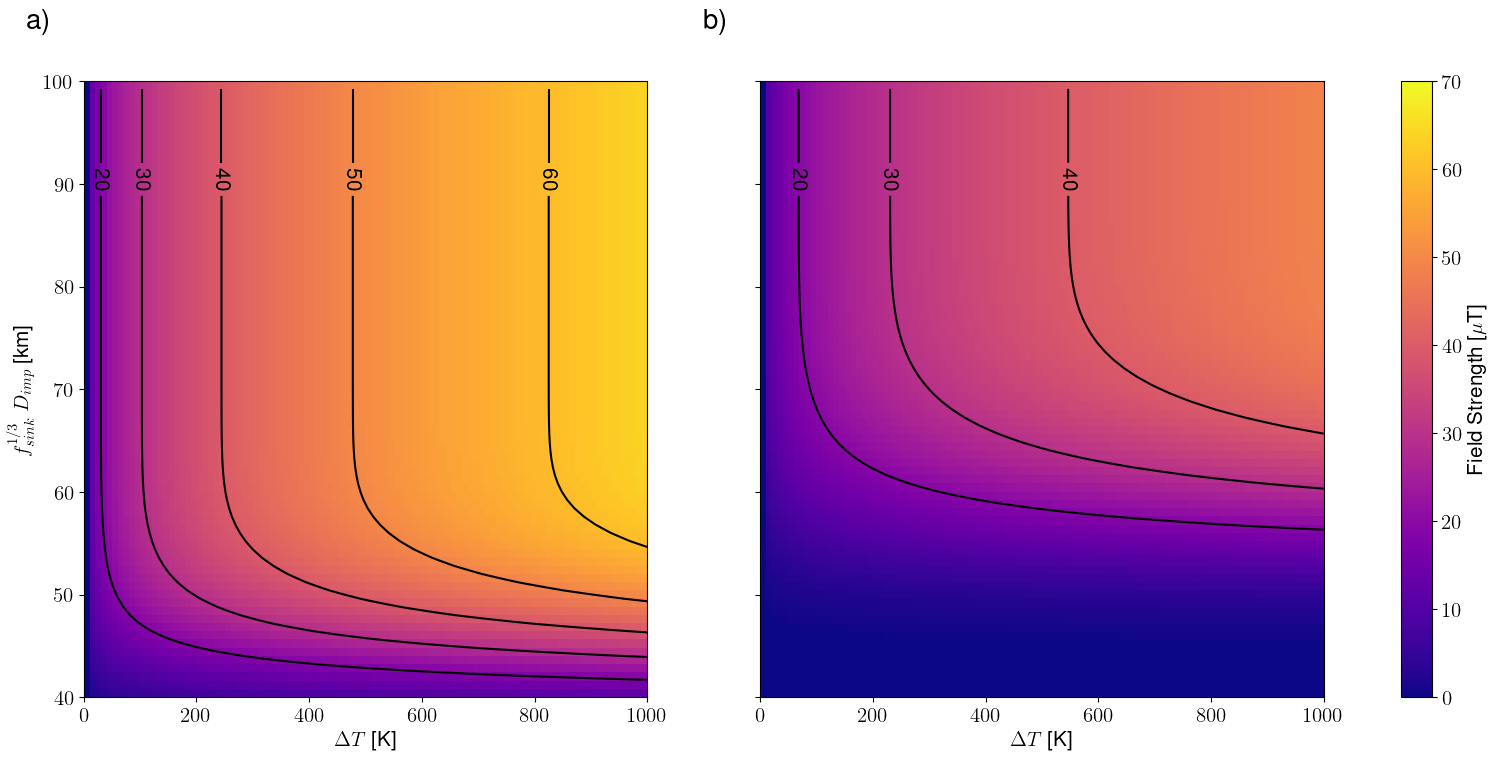

In [45]:
fig, ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,8))
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plot = ax[0].imshow(np.flipud(to_plot2[:75,:]), extent=(0,1000,40,100), aspect='auto', cmap='plasma',
                    vmin=0, vmax=70)
CS = ax[0].contour(ds, 2*rs[:75]/1e3, to_plot2[:75,:], [20,30,40,50,60], colors='k')
manual_locations = [(100,100), (400, 160), (800, 160)]
ax[0].clabel(CS, inline=1, fontsize=15, fmt={10:'10', 20:'20', 30:'30', 40:'40', 50:'50', 60:'60'})
ax[0].set_xlabel(r'$\Delta T$ [K]', fontsize=15)
ax[0].set_ylabel(r'$f_{sink}^{1/3}\ D_{imp}$ [km]', fontsize=15)
ax[0].tick_params(labelsize=15)

plot2 = ax[1].imshow(np.flipud(to_plot3[:75,:]), extent=(0,1000,40,100), aspect='auto', cmap='plasma',
                     vmin=0, vmax=70)
CS = ax[1].contour(ds, 2*rs[:75]/1e3, to_plot3[:75,:], [20,30,40,50], colors='k')
manual_locations = [ (400, 160), (800, 160),]
ax[1].clabel(CS, inline=1, fontsize=15, fmt={10:'10', 20:'20', 30:'30', 40:'40', 50:'50'})
ax[1].set_xlabel(r'$\Delta T$ [K]', fontsize=15)
ax[1].tick_params(labelsize=15)

cax,kw = matplotlib.colorbar.make_axes([a for a in ax.flat])
cbar = fig.colorbar(plot, cax, kw)
cbar.set_label(r'Field Strength [$\mu$T]', fontsize=15)
cbar.ax.tick_params(labelsize=15)

ax[0].text(-100., 105., "a)", fontsize=20)
ax[1].text(-100., 105., "b)", fontsize=20)
# plt.subplots_adjust(left=-0.3)

# plt.savefig('PaperFigs/ImpactorDwithDeltaT_advecTimev2.pdf', bbox_inches='tight')
plt.show()

# Supplemental Figures

# Figure S1)

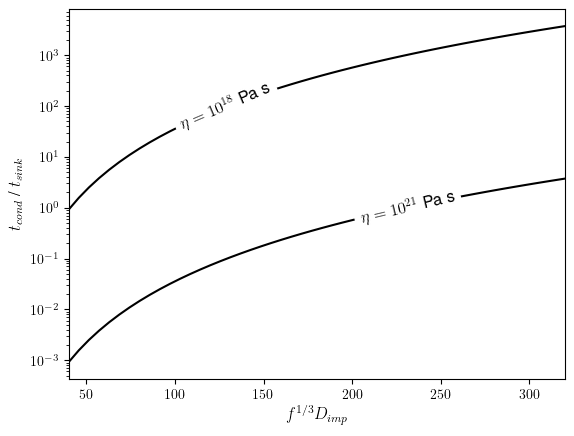

In [33]:
max_R = imp_from_crater(2400e3)/2
R = core_size(np.linspace(20e3, max_R))

n = 1e18
t_cond = R**2/alpha
t_sink = sink_time(R, n)
plt.plot(2*np.linspace(20e3, 160e3)/1e3, t_cond/t_sink, label=r'$\eta=10^{18}$ Pa s', c='k')

n = 1e21
t_sink = sink_time(R, n)
plt.plot(2*np.linspace(20e3, 160e3)/1e3, t_cond/t_sink, label=r'$\eta=10^{21}$ Pa s', c='k')
plt.yscale('log')

labelLines(plt.gca().get_lines(),fontsize=12)

plt.ylabel(r'$t_{cond}$ / $t_{sink}$', fontsize=12)
plt.xlabel(r'$f^{1/3}D_{imp}$', fontsize=12)
plt.xlim(40,320)

# plt.savefig('PaperFigs/TimeRatios.pdf', bbox_inches='tight')

plt.show()

# Figure S2)

In [36]:
max_R = imp_from_crater(2400e3)/2
therm_evol2 = []
blob = core_size(max_R)
L = layer(blob)
rs = np.arange(0, L+1, step=1)
ts = np.linspace(1, 30*86400, num=300)

for t in ts:
    therm_evol2.append(temps(rs, t, 500, 2300, L))
    
therm_evol2 = np.asarray(therm_evol2)

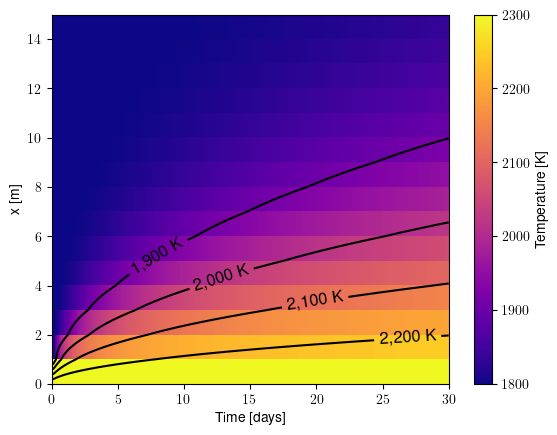

In [37]:
plt.imshow(np.flipud(therm_evol2[:,:15].T), extent=(0,30,0,15), aspect='auto', cmap='plasma')
cbar = plt.colorbar()
cbar.set_label(r'Temperature [K]')
CS = plt.contour(ts/(86400), rs[:15], np.transpose(therm_evol2[:,:15]), [1900, 2000, 2100,2200], colors='k')
manual_locations = [(7, 6), (13, 4), (20, 3), (27,1)]
plt.clabel(CS, inline=1, fontsize=12, fmt={1900:'1,900 K', 2000:'2,000 K', 2100:'2,100 K',
                                           2200:'2,200 K',},manual=manual_locations,)
plt.xlabel('Time [days]')
plt.ylabel('x [m]')

# plt.savefig('PaperFigs/LayerThermEvol_SPAdT500.pdf', bbox_inches='tight')
plt.show()